# NGC 7000 (North American Nebula) 3D Velocity Analysis II

*Eric G. Suchanek, Ph.D. 9/5/19*

This notebook analyzes stellar data extracted from the Gaia DR2 repository via my iPython notebook: <a href="./ExtractStars_batch_all.ipynb">ExtractStars_batch_all.ipynb</a>. The code blocks utilizes
the python-based <a href="https://docs.astropy.org/en/stable/index.html">*astropy*</a> object and method library and its associated <a href="https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html">*SkyCoord* class</a> to compute 3D stellar separations from positional and parallax data extracted from Gaia. See: <a href=https://het.as.utexas.edu/HET/Software/Astropy-1.0/coordinates/matchsep.html> Astropy Separations </a> for more information on the technique used. Clustering techniques are described in the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fclusterdata.html#scipy.cluster.hierarchy.fclusterdata"> SciPy documentation</a>.

<i>NB: the code relies on the routines stored in the file: <a href="./egs.py">egs.py</a> which should be located in the same directory as this notebook.</i>

## Preamble and globals. Always run the following cell first.

In [1]:
#
# Important libraries and global variables that the following cells rely on. Run this first. -egs-
# Last modification: 9/5/19
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

# plotting and visualization libraries
import plotly.offline
import plotly.express as px

# libraries for interactive plots
import ipywidgets as widgets
from ipywidgets import Layout, Box, widgets

# pandas routines
import pandas as pd
from pandas import DataFrame

# astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

# Aladin
import ipyaladin as ipyal
from ipyaladin import Aladin

# misc
from time import time
import datetime
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.cluster.hierarchy import fclusterdata

# the file egs.py must be included in the same directory as the notebook!
#from mirapy import *
import mirapy.egs as egs

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
# We go offline with cufflinks first, since this is all local
#
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True, theme="space")
init_notebook_mode(connected=True)

# absolute path for the location to read the data
Data_dir = "/home/suchanek/MIRA/data/"

# Global variables used by the following cells. If you export the cells to straight Python remember to
# include the appropriate libraries and variables from this area of the notebook!

# the current stellar data file generated by ExtractStars_batch_all.py. Make sure the file exists at the path
# specified!
# these were generated over the sizes with no statistical constraints. The only constraints
# were for non-null PMRA and PMDec and Parallax > 0.

#filename = "PM_all/NGC7000PM_20h58m47s_44d19m48s_1.0x1.0_all_vel.csv"
#filename = "PM_all/NGC7000PM_20h58m47s_44d19m48s_0.25x0.25_all_vel.csv"
filename = "PM_all/NGC7000PM_20h58m47s_44d19m48s_0.5x0.5_all_vel.csv"
#filename = "./ngc7000_30sec_circle.csv"

# make the velocity filename
vel_filename = Data_dir + filename
# A string name for the object we're analyzing. Used in the graphs
obj_name = "NGC7000 "

# extent of the current analysis - refer to filename for value
_extent = .5

_figwidth=800
_figheight=800

# the following are my (egs) home computing environments for comparison runs

#_sys = "iMac, 3.3 GHz Intel Core i5, 32 GB DDR3 1867 MHz RAM, OSX 10.15 beta"
_sys = 'PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04'
# _sys = 'PC, 3.0 GHz Intel Core i5', 16 GB DDR3 1867 MHz RAM, Windows 10, Parallels'

#
# We go offline with cufflinks since the plots generated are all local to this machine
#
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True, theme='space')

start = time()
egs.pprint_elapsed(start,_sys)
# read the data into a data frame
# this will be our working global dataframe for the following cells.
STARS = egs.read_Gaia_stars(vel_filename)
if STARS is False:
    print("Can't open file: " + vel_filename)
else:
    print('Read in:',len(STARS),'stars', 'for extent', _extent, 'degrees.')
    t = Table.read(vel_filename,format="ascii.csv")
    print('The following image is extracted using Aladin and represents the current region of interest (width)')
    print()

egs.pprint_elapsed(start,_sys)

# it's simple to display the target using the current vel files FOV
aladin= Aladin(target=obj_name, fov=_extent)

aladin


Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


Elapsed: 0:00:00.000034 on PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04
Read in: 12129 stars for extent 0.5 degrees.
The following image is extracted using Aladin and represents the current region of interest (width)

Elapsed: 0:00:00.120836 on PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04


Aladin(fov=0.5, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

In [2]:
# add our table
aladin.add_table(t)

In [3]:
# linked views
t = Table.read(vel_filename,format="ascii.csv")
a = Aladin(layout=Layout(width='33.33%'), target=obj_name, fov=_extent)
b = Aladin(layout=Layout(width='33.33%'), survey='P/DSS2/red')
c = Aladin(layout=Layout(width='33.33%'), survey='P/2MASS/color')

# synchronize target between 3 widgets
widgets.jslink((a, 'target'), (b, 'target'))
widgets.jslink((b, 'target'), (c, 'target'))

# synchronize FoV (zoom level) between 3 widgets
widgets.jslink((a, 'fov'), (b, 'fov'))
widgets.jslink((b, 'fov'), (c, 'fov'))

items = [a, b, c]

box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    border='solid',
                    width='100%')
box = Box(children=items, layout=box_layout)
box


Box(children=(Aladin(fov=0.5, layout=Layout(width='33.33%'), options=['allow_full_zoomout', 'coo_frame', 'fov'…

In [4]:

a.add_table(t)
b.add_table(t)
c.add_table(t)

## Clustering trials using various metrics and algorithms. 

In [5]:
# see if we can do clustering based on velocities
low = 600
high = 2000
cut = 100.0

# return a new DataFrame containing the rows between the distance constraint
close = egs.return_constraint(STARS,'Distance',low,high)
print(str(len(close)) + str.format(" stars found between {} and {} pc.",low,high))

# convert this to a list of SkyCoord objects for the close stars
#close_sc = egs.make_skycoord_list(close)
start = time()

vels = egs.make_velocity_array(close)

clusters = fclusterdata(vels,1,'distance')
egs.pprint_elapsed(start,_sys)
print()

print(clusters)

4778 stars found between 600 and 2000 pc.
Elapsed: 0:00:00.573388 on PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04

[1 1 1 ... 1 1 1]


3624 stars found between 500 and 1500 pc.
Elapsed: 0:00:05.842439 on PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04



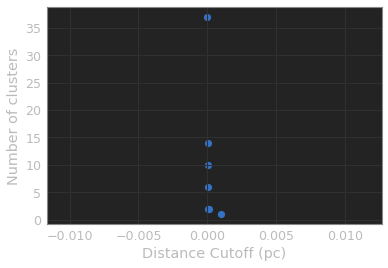

In [6]:
# Analyze clustering based on 3D velocity data by using the traditional
# euclidean distance metric.
start = time()
low = 500
high = 1500

# return a new DataFrame containing the rows between the distance constraint
close = egs.return_constraint(STARS,'Distance',low,high)

# convert this to a list of SkyCoord objects for the close stars
close_sc = egs.make_skycoord_list(close)
print(str(len(close)) + str.format(" stars found between {} and {} pc.",low,high))

# extract the cartesian X,Y,Z values, without units (pc)
vels = egs.make_velocity_array(close)
#
# Iterate over a number of cluster distance cutoffs and determine the number of clusters found,
# plot them on a scatterplot
#
# make a list for the cutoff we want to analyze
cutoffs = [.00001, .00002, .00003, .00005, .00009, .0001, .001]

# create a list of the maximum number of clusters by iterating over the distance cutoffs
# easy to do this with list comprehension:
max_clusters = [fclusterdata(vels,cut,'distance').max() for cut in cutoffs]

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(cutoffs,max_clusters,s=50)

ax.set_xlabel('Distance Cutoff (pc)')
ax.set_ylabel('Number of clusters')
#plt.colorbar(scatter)

fig.show()

egs.pprint_elapsed(start,_sys)
print()


8964 stars found between 600 and 5000 pc.
Elapsed: 0:01:08.178598



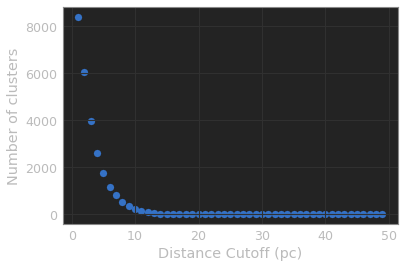

In [7]:
# Analyze clustering based on 3D cartesian positional data by using the traditional
# euclidean distance metric.
start = time()
low = 600
high = 5000

# return a new DataFrame containing the rows between the distance constraint
close = egs.return_constraint(STARS,'Distance',low,high)

# convert this to a list of SkyCoord objects for the close stars
close_sc = egs.make_skycoord_list(close)
print(str(len(close)) + str.format(" stars found between {} and {} pc.",low,high))

# extract the cartesian X,Y,Z values, without units (pc)
cartesian_pos = egs.make_cartesian_list_vals(close_sc)

#
# Iterate over a number of cluster distance cutoffs and determine the number of clusters found,
# plot them on a scatterplot
#
# make a list for the cutoff we want to analyze
cutoffs = range(1,50,1)

# create a list of the maximum number of clusters by iterating over the distance cutoffs
# easy to do this with list comprehension:
max_clusters = [fclusterdata(cartesian_pos,cut,'distance').max() for cut in cutoffs]

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(cutoffs,max_clusters,s=50)

ax.set_xlabel('Distance Cutoff (pc)')
ax.set_ylabel('Number of clusters')
#plt.colorbar(scatter)

fig.show()

egs.pprint_elapsed(start)
print()


## Distributions

In [9]:
#
# look at the distance distribution for a single random star compared to all stars. testing function
start = time()

low = 570.0
high = 5000.0

close = egs.return_constraint(STARS,'Distance',low,high)
close_sc = egs.make_skycoord_list(close)

index = random.randint(0,len(close))
star = egs.make_single_skycoord(close,index)

sep = egs.compute_3d_separations(star,close)
df = DataFrame(sep,columns=["Separation"])

fig = df[["Separation"]].iplot(
    kind="hist", bins=200,
    title=str.format("Separation (pc) from star {}, {} stars total between {} and {} pc",
                    index,len(sep),low,high),
    xTitle='Separation (pc)',yTitle='Count')
egs.pprint_elapsed(start,_sys)
print()

Elapsed: 0:00:11.001546 on PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04



In [10]:
#
# plot histograms for the X, Y, Z cartesian coordinates for the stars
#
start = time()
sc = egs.make_skycoord_list(close)

xpos,ypos,zpos = egs.extract_cartesian_vectors_vals(sc)
#print(xpos.min(),xpos.max())

df = DataFrame(columns=["X", "Y", "Z"])
df['X'] = xpos
df['Y'] = ypos
df['Z'] = zpos


df[["X","Y","Z"]].iplot(kind="histogram", bins=200,
                title=str.format("Cartesian Coordinates, {} stars total",str(len(close))),
                xTitle='Coordinate',yTitle='Count')

egs.pprint_elapsed(start,_sys)
print()

Elapsed: 0:00:26.116712 on PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04



In [11]:
import plotly.express as px

fig = px.scatter_3d(df, x='X', y='Y', z='Z')
fig.show()

## Benchmarking and testing internal routines

In [13]:
# make a list of SkyCoord objects representing all of the stars read in initially

start = time()
sc_list = egs.make_skycoord_list(STARS)

egs.pprint_elapsed(start,_sys)
print()

Elapsed: 0:00:12.532003 on PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04



In [14]:
# make a NEW dataframe containing the original stars AND a SkyCoord object initialized with Proper Motion
# parameters. This entries of this column is directly associated the corresponding Gaia row. The column
# name is SkyCoord
start = time()
stars_full_sc = egs.add_skycoords(STARS)
# print(stars_full_sc['SkyCoord'])
egs.pprint_elapsed(start,_sys)
print()

Elapsed: 0:00:12.413625 on PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04



In [15]:
# extract the earlier-computed 3D VX, VY, VZ elements into an array of 3d vectors.
start = time()
vel_array = egs.make_velocity_array(STARS)
#print(vel_array)
egs.pprint_elapsed(start,_sys)
print()

Elapsed: 0:00:00.877789 on PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04



In [16]:
start = time()
sc_list = egs.make_skycoord_list(STARS)

cartpos_starlist = egs.make_cartesian_list(sc_list)
#print(cartpos_starlist)
egs.pprint_elapsed(start,_sys)
print()

Elapsed: 0:00:32.500456 on PC, 3.0 GHz Intel Core i5, 16 GB DDR4 2166 MHz RAM, Ubuntu 18.04



In [ ]:
start = time()

cartpos_starlist_vals = egs.make_cartesian_list_vals(sc_list)
#print(cartpos_starlist)
egs.pprint_elapsed(start,_sys)
print()

In [ ]:
#
# grab a random star and search for stars within the specified 3D separation for all stars
#

start = time()
starcount = len(STARS)
index = random.randint(0,starcount)
center = egs.make_single_skycoord(STARS,index)

# return the number of neighbors and the SkyCoord list containing them within X pc
numb_stars,neighbors = egs.extract_stars_by_separation(center,STARS,80*u.pc)

print(numb_stars)
egs.pprint_elapsed(start,_sys)
print()

In [ ]:
#
#
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(xpos,ypos,c=clusters,s=50)
#for i,j in centers:
#    ax.scatter(i,j,s=50,c='red',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)

fig.show()